In [1]:
from src_dir import *
import numpy as np

dim=25


x0=np.squeeze(np.zeros((dim,dim)))
A=mk_laplace_2d(dim,dim)

retrain_freq=1
e1 = 1e-3
e2 = 1e-5
nmax_iter = 50
restart   = 64


DomainL=-1.0
DomainR=1.0

x1=np.linspace(DomainL,DomainR,dim)
x2=np.linspace(DomainL,DomainR,dim)
X, Y = np.meshgrid(x1, x2, sparse=False, indexing='ij')

n_steps =100
InputDim=dim*dim
HiddenDim=dim*dim
OutputDim=dim*dim

In [2]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed_2DFlat(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b ,x0, e, nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [3]:
from src_dir import *



ML_GMRES_Time_list=[]

Err_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_timeP1_ML_list=[]
run_timeP2_ML_list=[]

run_time_list=[]
GmresRunTimeOriginal=[]
GmresRunTimeOriginal2=[]

trainTime_list=[]


debug=True
refine1=False
refine2=True

blist=[]
reslist=[]

eps=0.0001

for ProbIdx in range(n_steps):

    b=(np.sin(ProbIdx)+eps)*X+(np.cos(ProbIdx)+eps)*Y
    b_flat=np.reshape(b,(1,-1),order='F').squeeze(0)
    b_norm=np.linalg.norm(b_flat)


    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine1,blist,reslist,Err_list)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm,Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine2,blist,reslist,Err_list)
    Out2=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]

    run_timeP1_ML_list.append(run_time1_ML)
    run_timeP2_ML_list.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)
    



    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[10])
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    
    GmresRunTimeOriginal.append(run_time1)
    GmresRunTimeOriginal2.append(run_time2)
    run_time_list.append(run_time1+run_time2)
    
    print(ProbIdx)


run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)


print("Runtime of Non-decorated version is:")
print(run_time)

print("Runtime of MLGMRES decorator is:")
print(run_time_ML)


print("Runtime of training (backprop) is:")
print(trainTime_total)


0
1
Final loss: 9.739745109982323e-06
parameters 781875
Initial Training
2
size 27
0.08933341829243384 0.34847367640566335
0.2876323520004007 0.19692406149988528 0.08933341829243384 0.34847367640566246
0.2876323520004007 0.19692406149988528 0.08933341829243384 0.34847367640566246
3
size 27
0.1387781170460529 0.34847367640566335
0.2641480040001625 0.2417103150000912 0.1387781170460529 0.2189035473490477
0.2641480040001625 0.2417103150000912 0.1387781170460529 0.2189035473490477
4
size 27
0.09431983544470174 0.34847367640566335
0.23074046900001122 0.24918954466678164 0.09431983544470174 0.19219507058138277
0.23074046900001122 0.24918954466678164 0.09431983544470174 0.19219507058138277
5
size 27
0.027145681676664674 0.34847367640566335
0.1210858009999356 0.26084027500019147 0.027145681676664674 0.10747712359439615
0.1210858009999356 0.26084027500019147 0.027145681676664674 0.10747712359439615
6
size 27
0.010394443942123244 0.34847367640566335
0.14859909699953278 0.2259016565001275 0.01039

40
size 27
0.017962325425714534 0.34847367640566335
0.14511889899949892 0.12530520687992974 0.017962325425714534 0.010518887054346953
0.14511889899949892 0.12530520687992974 0.017962325425714534 0.010518887054346953
41
size 27
0.007018401334523887 0.34847367640566335
0.1173691650001274 0.12656401235988596 0.007018401334523887 0.010639738862766986
0.1173691650001274 0.12656401235988596 0.007018401334523887 0.010639738862766986
42
size 27
0.016420614705787467 0.34847367640566335
0.11640713299948402 0.12667553135986964 0.016420614705787467 0.010556693867148515
0.11640713299948402 0.12667553135986964 0.016420614705787467 0.010556693867148515
43
size 27
0.0017877456650880197 0.34847367640566335
0.11665588899995782 0.12680293879984675 0.0017877456650880197 0.010446408602169057
0.11665588899995782 0.12680293879984675 0.0017877456650880197 0.010446408602169057
44
size 27
0.001051526607041059 0.34847367640566335
0.1439531320002061 0.12569590163984684 0.001051526607041059 0.010051957945310415
0.

0.12579938099952415 0.1320201092399293 0.006178474170950304 0.005712560486668311
0.12579938099952415 0.1320201092399293 0.006178474170950304 0.005712560486668311
78
size 27
0.004919429121495015 0.34847367640566335
0.12679236399981164 0.13130118303990457 0.004919429121495015 0.005904400092230248
0.12679236399981164 0.13130118303990457 0.004919429121495015 0.005904400092230248
79
size 27
0.010028986202288204 0.34847367640566335
0.1463494500003435 0.1306139526399056 0.010028986202288204 0.006057885883213914
0.1463494500003435 0.1306139526399056 0.010028986202288204 0.006057885883213914
80
size 27
0.008955973678781417 0.34847367640566335
0.147843742999612 0.13179762391991973 0.008955973678781417 0.006386513515530343
0.147843742999612 0.13179762391991973 0.008955973678781417 0.006386513515530343
InnerProd [[ 1.         -0.65359749  0.28377267]
 [-0.65359749  1.          0.54025664]
 [ 0.28377267  0.54025664  1.        ]]
retraining
3
Final loss: 0.0036322581581771374
parameters 781875
81
si

In [4]:
import matplotlib.pyplot as pp
from src_dir import *

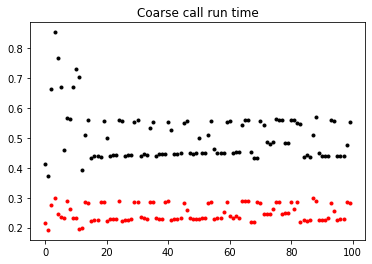

In [5]:
pp.plot(run_timeP1_ML_list,'.k',GmresRunTimeOriginal,'.r')
pp.title('Coarse call run time')

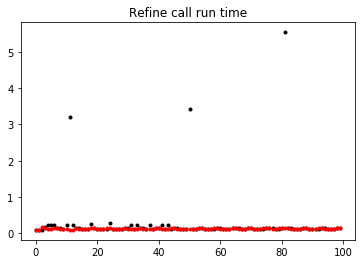

In [6]:
pp.plot(run_timeP2_ML_list,'.k',GmresRunTimeOriginal2,'.r')
pp.title('Refine call run time')
# pp.ylim((0, 0.2))

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:65: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


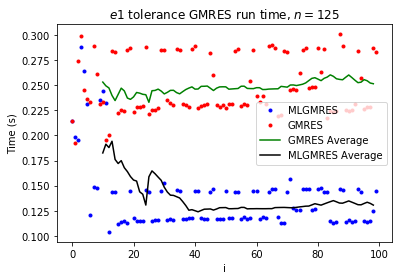

In [7]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))
count=np.arange(0,n_steps)


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')




pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n=125$')
pp.legend(loc='best')